In [2]:
### run this cell first
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Description

The 'players.csv' dataset has:
- 196 observations
- 7 variables:
    - experience. string. the player's prior experience with Minecraft, ranging from 'Beginner' to 'Pro'.
    - subscribe. boolean. whether or not the player has subscribed to the game-related newsletter.
    - hashedEmail. string. scrambled version of the player's email.
    - played_hours. double. the amount of time the player has spent playing on the Minecraft server in hours, rounded to one decimal place. Mean: 5.85
    - name. string. the player's name.
    - gender. string. the player's gender.
    - Age. integer. the player's age in years. Mean: 21.14

Issues:
- Its variables are named using varying formats (Age is the only capitalized variable, camelCase is used for only one of two two-word variables)
- The number of observations is somewhat small
- There are far fewer aged players than there are young ones

## Questions

I will be addressing question 2: 'Which kinds of players are likely to contribute the most data?' The specific question that I will be asking is 'Can player age predict hours played in the players dataset?' More hours played means more data contributed, and I've chosen to try and link hours played to age.

## Exploratory data analysis and visualization

In [7]:
players <- read_csv("data/players.csv") # dataset can be loaded!
# + data already tidy as far as i can tell.
hours <- summarize(players, played_hours = mean(played_hours, na.rm = TRUE))
hours
age <- summarize(players, Age = mean(Age, na.rm = TRUE))
age

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


played_hours
<dbl>
5.845918


Age
<dbl>
21.13918


In [26]:
# here's the table with the means
means <- matrix(c(5.85, 21.14), ncol=2, byrow=TRUE)
colnames(means) <- c('Played_Hours','Age')
rownames(means) <- c('Mean')
means <- as.table(means)
means

     Played_Hours   Age
Mean         5.85 21.14

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


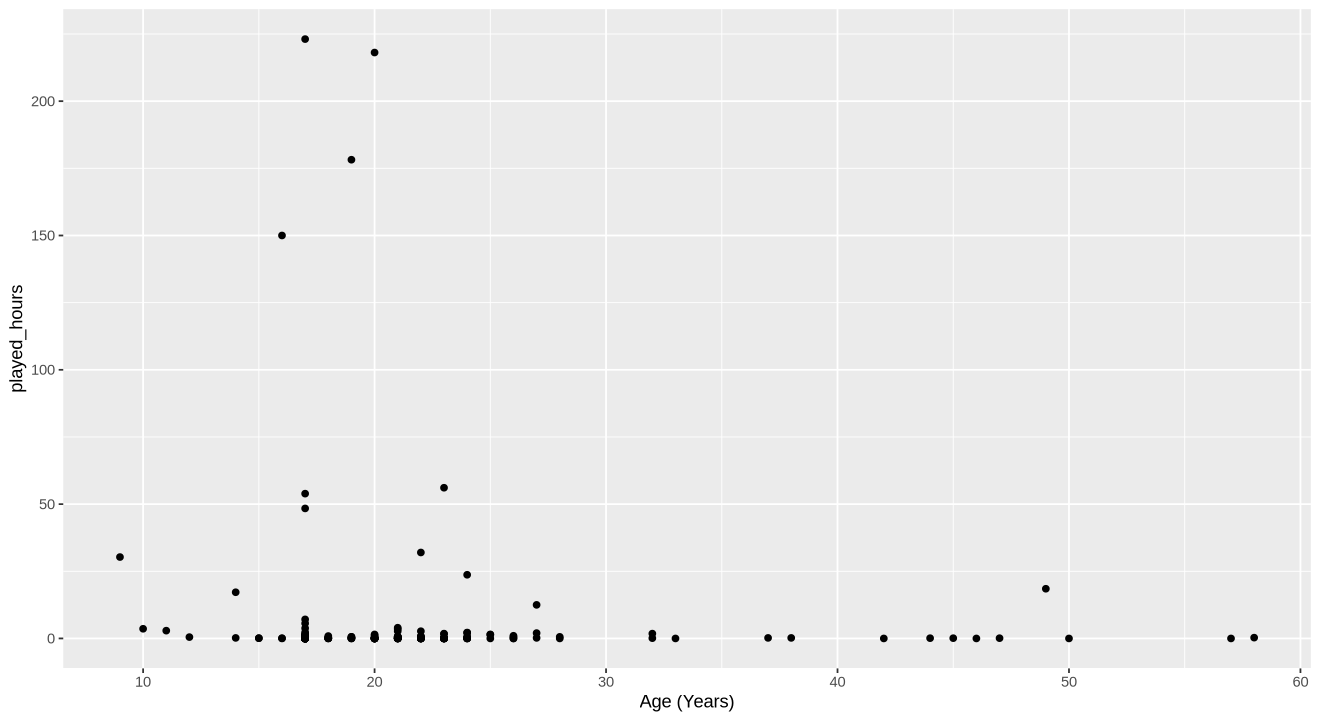

In [39]:
options(repr.plot.width = 11, repr.plot.height = 6)
age_vs_hours <- ggplot(players, aes(x=Age, y=played_hours)) +
    geom_point() +
    labs(x="Age (Years)", "Average played (Hours)")
age_vs_hours

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


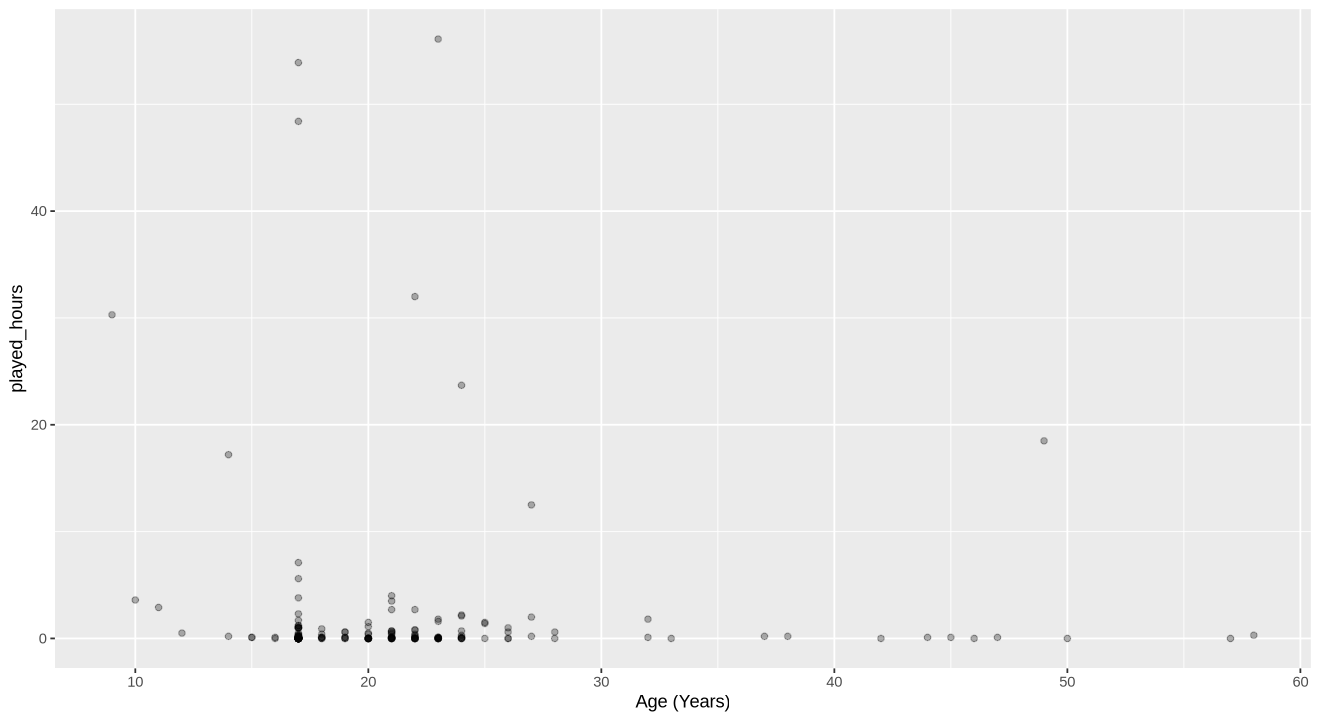

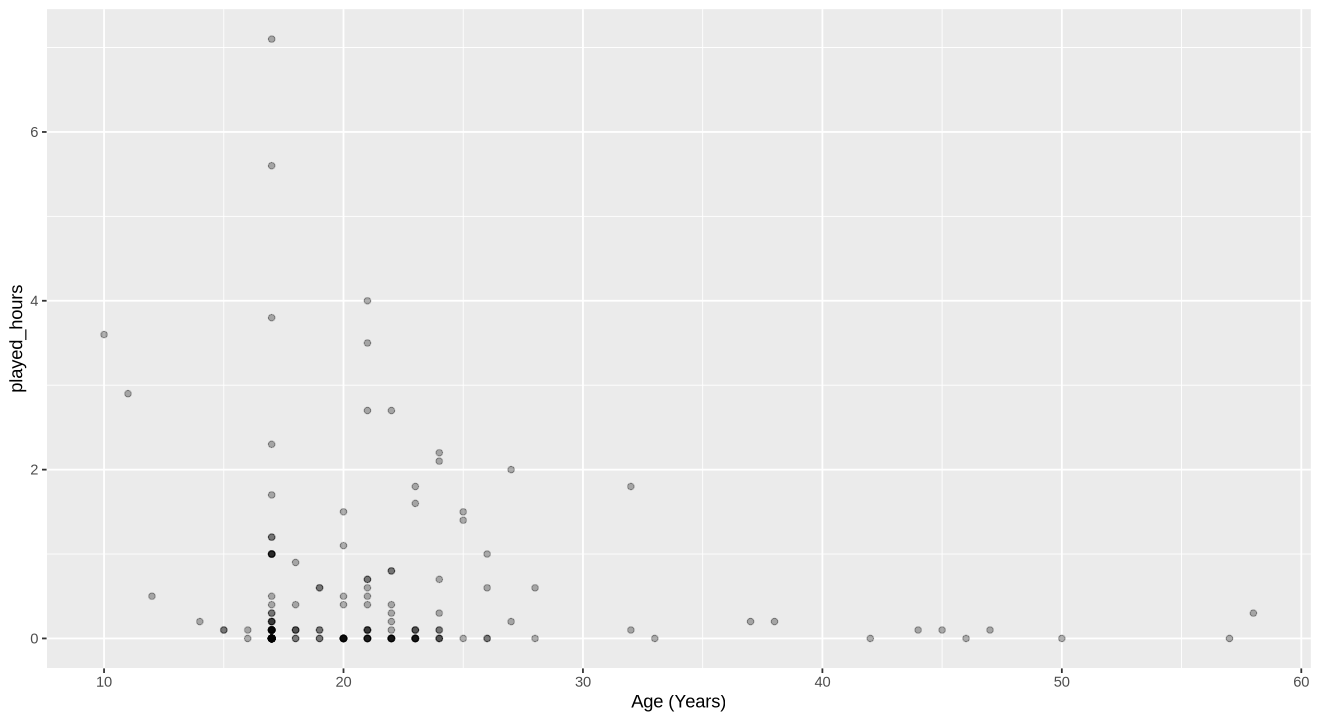

In [44]:
players_sub100h <- filter(players, played_hours < 100)
age_vs_hours_2 <- ggplot(players_sub100h, aes(x=Age, y=played_hours)) +
    geom_point(alpha = 0.3) +
    labs(x="Age (Years)", "Average played (Hours)")
age_vs_hours_2

players_sub10h <- filter(players, played_hours < 10)
age_vs_hours_3 <- ggplot(players_sub10h, aes(x=Age, y=played_hours)) +
    geom_point(alpha = 0.3) +
    labs(x="Age (Years)", "Average played (Hours)")
age_vs_hours_3

The main insight that we gain from the tables is that people under 30 tend to play for longer, peaking around 16. People under 30 also seem to be more likely to play more than 10 hours, but there are far more points of data under 30 than ther are over, so it's not completely conclusive.

## Methods and plan

I would propose K-NN Regression as the method to address the question of interest. The value we want to predict is numerical, not categorical, and does not seem to follow a straight line. This would make K-NN regression the best prediction model fior this data out of the ones we have covered so far.
- Assumptions: n/a
- Limitations: For a very large dataset, the prediction will be much slower. Also, the predctions will not do well with values outside the range of the training data. So, in actuality, if there are enough people playing upwards of 250 hours on the server, or who are older than 60, the model won't perform too well. The program might also act strangely since the points form vertical lines in each age grouping.
- Processing: At the beginning, 80/20 split for training and testing, then split the training data into 5 pieces to perform 5-fold cross validation. 10-fold cross validation seems unwise as there aren't very many observations in the dataset.